In [3]:
!wget https://s3.us-west-1.wasabisys.com/dphi/public-datasets/Data%20Sprint%2080%20Sports%20Genre%20Identification/Sports_Identification.zip

--2023-01-30 12:21:44--  https://s3.us-west-1.wasabisys.com/dphi/public-datasets/Data%20Sprint%2080%20Sports%20Genre%20Identification/Sports_Identification.zip
Resolving s3.us-west-1.wasabisys.com (s3.us-west-1.wasabisys.com)... 38.146.40.13, 38.146.40.22, 38.146.40.17, ...
Connecting to s3.us-west-1.wasabisys.com (s3.us-west-1.wasabisys.com)|38.146.40.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 352952524 (337M) [application/x-zip-compressed]
Saving to: ‘Sports_Identification.zip.1’

Sports_Identificati 100%[===================>] 336.60M  67.3MB/s    in 4.9s    

2023-01-30 12:21:49 (69.3 MB/s) - ‘Sports_Identification.zip.1’ saved [352952524/352952524]



In [4]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-7build1).
0 upgraded, 0 newly installed, 0 to remove and 115 not upgraded.


In [5]:
!7za x Sports_Identification.zip


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=C.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Sca        1 file, 352952524 bytes (337 MiB)

Extracting archive: Sports_Identification.zip
 30% 4096 Op            --
Path = Sports_Identification.zip
Type = zip
Physical Size = 352952524

    
Would you like to replace the existing file:
  Path:     ./Sports Identification/Testing_set.csv
  Size:     64055 bytes (63 KiB)
  Modified: 2022-06-23 09:18:44
with the file from archive:
  Path:     Sports Identification/Testing_set.csv
  Size:     64055 bytes (63 KiB)
  Modified: 2022-06-23 09:18:44
? (Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? ^C
(Y)es / (N)o / (A)lways / (S)kip all / A(u)to rename all / (Q)uit? 

In [6]:
import os
import random
import skimage.data
import skimage.transform
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
from skimage import io
from matplotlib.image import imread
import keras
import time
import cv2
# Allow image embeding in notebook
%matplotlib inline

In [7]:
labels = pd.read_csv("Sports Identification/Training_set.csv")
labels.head() 

,filename,label
0,Image_1.jpg,golf
1,Image_2.jpg,roller derby
2,Image_3.jpg,high jump
3,Image_4.jpg,bungee jumping
4,Image_5.jpg,rugby


In [8]:
labels['label'].nunique()

100

In [9]:
file_paths = [[fname, 'Sports Identification/train/' + fname] for fname in labels['filename']]

In [10]:
if len(labels) == len(file_paths):
    print('Number of labels i.e. ', len(labels), 'matches the number of filenames i.e. ', len(file_paths))
else:
    print('Number of labels does not match the number of filenames')

Number of labels i.e.  9500 matches the number of filenames i.e.  9500


In [34]:
images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
images.head()

,filename,filepaths
0,Image_1.jpg,Sports Identification/train/Image_1.jpg
1,Image_2.jpg,Sports Identification/train/Image_2.jpg
2,Image_3.jpg,Sports Identification/train/Image_3.jpg
3,Image_4.jpg,Sports Identification/train/Image_4.jpg
4,Image_5.jpg,Sports Identification/train/Image_5.jpg


In [35]:
train_data = pd.merge(images, labels, how = 'inner', on = 'filename')
train_data.head()

,filename,filepaths,label
0,Image_1.jpg,Sports Identification/train/Image_1.jpg,golf
1,Image_2.jpg,Sports Identification/train/Image_2.jpg,roller derby
2,Image_3.jpg,Sports Identification/train/Image_3.jpg,high jump
3,Image_4.jpg,Sports Identification/train/Image_4.jpg,bungee jumping
4,Image_5.jpg,Sports Identification/train/Image_5.jpg,rugby


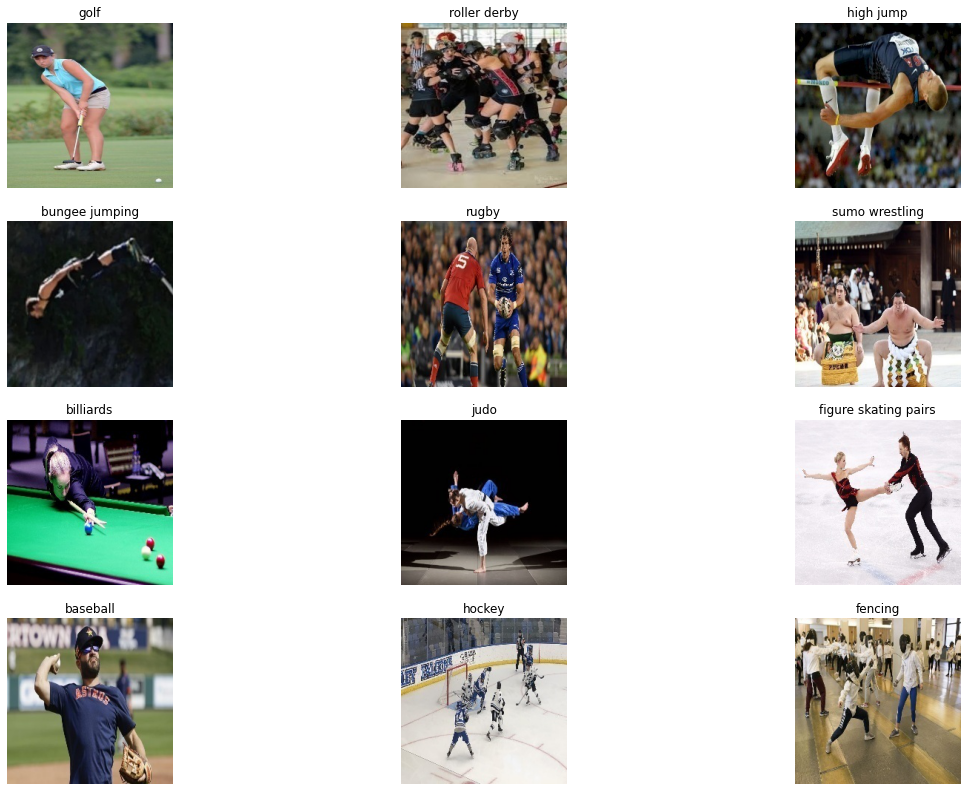

In [36]:
fig, axis = plt.subplots(4, 3,figsize=(20, 14))

for i, ax in enumerate(axis.flat):
    ax.imshow(plt.imread(train_data.filepaths[i]))
    ax.set_title(train_data.label[i])
    ax.axis('off')
    
plt.show()

In [12]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_data['label'] = le.fit_transform(train_data['label'])

In [13]:
from joblib import dump
dump(le, 'encoder.pkl', )

['encoder.pkl']

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
df = train_data[['filepaths', 'label']]

In [39]:
df.head()

,filepaths,label
0,Sports Identification/train/Image_1.jpg,golf
1,Sports Identification/train/Image_2.jpg,roller derby
2,Sports Identification/train/Image_3.jpg,high jump
3,Sports Identification/train/Image_4.jpg,bungee jumping
4,Sports Identification/train/Image_5.jpg,rugby


In [40]:
test_ratio = 0.15

train, test = train_test_split(df, test_size=test_ratio, random_state=101)
len(train), len(test)

(8075, 1425)

In [41]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [42]:
train_data_gen = ImageDataGenerator(rotation_range=30, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.4, horizontal_flip=True, rescale=1/255,)

In [43]:
test_data_gen = ImageDataGenerator(rescale=1/255)

In [44]:
image_shape = (299, 299, 3)

In [45]:
training_set = train_data_gen.flow_from_dataframe(dataframe=train, x_col="filepaths", y_col="label", target_size=image_shape[:2], class_mode='categorical', batch_size=64, )
testing_set = test_data_gen.flow_from_dataframe(dataframe=test, x_col="filepaths", y_col="label", target_size=image_shape[:2], class_mode='categorical', batch_size=64, shuffle=False)

Found 8075 validated image filenames belonging to 100 classes.
Found 1425 validated image filenames belonging to 100 classes.


In [46]:
training_set.class_indices

{'air hockey': 0,
 'ampute football': 1,
 'archery': 2,
 'arm wrestling': 3,
 'axe throwing': 4,
 'balance beam': 5,
 'barell racing': 6,
 'baseball': 7,
 'basketball': 8,
 'baton twirling': 9,
 'bike polo': 10,
 'billiards': 11,
 'bmx': 12,
 'bobsled': 13,
 'bowling': 14,
 'boxing': 15,
 'bull riding': 16,
 'bungee jumping': 17,
 'canoe slamon': 18,
 'cheerleading': 19,
 'chuckwagon racing': 20,
 'cricket': 21,
 'croquet': 22,
 'curling': 23,
 'disc golf': 24,
 'fencing': 25,
 'field hockey': 26,
 'figure skating men': 27,
 'figure skating pairs': 28,
 'figure skating women': 29,
 'fly fishing': 30,
 'football': 31,
 'formula 1 racing': 32,
 'frisbee': 33,
 'gaga': 34,
 'giant slalom': 35,
 'golf': 36,
 'hammer throw': 37,
 'hang gliding': 38,
 'harness racing': 39,
 'high jump': 40,
 'hockey': 41,
 'horse jumping': 42,
 'horse racing': 43,
 'horseshoe pitching': 44,
 'hurdles': 45,
 'hydroplane racing': 46,
 'ice climbing': 47,
 'ice yachting': 48,
 'jai alai': 49,
 'javelin': 50,
 '

In [22]:
testing_set

<h2>AlexNet

In [38]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 96, kernel_size=(11,11), strides = (4,4), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4096, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(100, activation="softmax")
])

2023-01-29 11:49:44.783854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 11:49:44.873574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 11:49:44.874314: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 11:49:44.876994: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [37]:
early_stop = [EarlyStopping(monitor='val_loss', patience=5, verbose=2)]

In [40]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Recall'])

In [41]:
model.fit(training_set, batch_size=64, epochs=100, callbacks=[early_stop], validation_data=testing_set, )

2023-01-29 11:50:47.917145: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005
2023-01-29 11:50:53.394648: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
127/127 [==============================] - 174s 1s/step - loss: 10.3116 - accuracy: 0.0196 - recall: 0.0033 - val_loss: 4.7446 - val_accuracy: 0.0133 - val_recall: 0.0000e+00
Epoch 2/100
127/127 [==============================] - 172s 1s/step - loss: 4.7286 - accuracy: 0.0263 - recall: 6.1920e-04 - val_loss: 4.5254 - val_accuracy: 0.0218 - val_recall: 0.0000e+00
Epoch 3/100
127/127 [==============================] - 172s 1s/step - loss: 4.5112 - accuracy: 0.0365 - recall: 0.0016 - val_loss: 4.3254 - val_accuracy: 0.0428 - val_recall: 0.0000e+00
Epoch 4/100
127/127 [==============================] - 172s 1s/step - loss: 4.3900 - accuracy: 0.0390 - recall: 0.0012 - val_loss: 4.8630 - val_accuracy: 0.0175 - val_recall: 0.0000e+00
Epoch 5/100
 69/127 [===============>..............] - ETA: 1:15 - loss: 4.3521 - accuracy: 0.0362 - recall: 0.0021

KeyboardInterrupt: 

<h2>VGG19

In [43]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(include_top=False, weights='imagenet', input_shape=(299,299,3), pooling='avg')
vgg.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0     

In [44]:
model = tf.keras.Sequential()

# only do this when you are using pre trained weights.
for layer in model.layers:
    layer.trainable=False

# adding fully connected layers
model.add(vgg)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(100, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               12900     
Total params: 20,201,508
Trainable params: 20,201,508
Non-trainable params: 0
__________________________________________

In [45]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'Recall'])

In [46]:
model.fit(training_set, batch_size=64, epochs=100, callbacks=[early_stop], validation_data=testing_set,)

Epoch 1/100
127/127 [==============================] - 222s 2s/step - loss: 4.9770 - accuracy: 0.0100 - recall: 0.0000e+00 - val_loss: 4.6057 - val_accuracy: 0.0077 - val_recall: 0.0000e+00
Epoch 2/100
 21/127 [===>..........................] - ETA: 2:48 - loss: 4.6048 - accuracy: 0.0082 - recall: 0.0000e+00

KeyboardInterrupt: 

<h2>Inception V3


In [51]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
i_model = InceptionV3(weights= 'imagenet', include_top=False, input_shape=(299, 299, 3))

In [52]:
for layer in i_model.layers:
    layer.trainable = False
    
i_model.summary() 

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_99 (Conv2D)              (None, 149, 149, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_99 (BatchNo (None, 149, 149, 32) 96          conv2d_99[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_99[0][0]     
_______________________________________________________________________________________

In [53]:
model = Sequential()
model.add(i_model)

model.add(GlobalAveragePooling2D())
model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(100, activation = 'softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               262272    
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               12900     
Total params: 22,077,956
Trainable params: 275,172
Non-trainable params: 21,802,784
_________________________________________________________________


In [54]:
model.compile(optimizer = 'adam',
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [55]:
model.fit(training_set, batch_size=64, epochs=100, callbacks=[early_stop], validation_data=testing_set,)

Epoch 1/100
127/127 [==============================] - 182s 1s/step - loss: 2.9278 - accuracy: 0.3266 - val_loss: 1.3923 - val_accuracy: 0.6540
Epoch 2/100
127/127 [==============================] - 177s 1s/step - loss: 1.5158 - accuracy: 0.5976 - val_loss: 0.9280 - val_accuracy: 0.7509
Epoch 3/100
127/127 [==============================] - 176s 1s/step - loss: 1.1977 - accuracy: 0.6654 - val_loss: 0.7706 - val_accuracy: 0.7705
Epoch 4/100
127/127 [==============================] - 175s 1s/step - loss: 1.0390 - accuracy: 0.7012 - val_loss: 0.7810 - val_accuracy: 0.7621
Epoch 5/100
127/127 [==============================] - 175s 1s/step - loss: 0.9516 - accuracy: 0.7304 - val_loss: 0.6962 - val_accuracy: 0.8000
Epoch 6/100
127/127 [==============================] - 175s 1s/step - loss: 0.8637 - accuracy: 0.7512 - val_loss: 0.6255 - val_accuracy: 0.8253
Epoch 7/100
127/127 [==============================] - 176s 1s/step - loss: 0.8272 - accuracy: 0.7511 - val_loss: 0.6249 - val_accuracy:

In [56]:
model.save('inception_classifier.h5')

In [57]:
pred = model.predict(testing_set)

In [58]:
preds = np.argmax(pred, axis=1)

In [59]:
from sklearn.metrics import classification_report, confusion_matrix

In [60]:
print(classification_report(testing_set.classes, preds))

              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       0.80      1.00      0.89         8
           2       1.00      1.00      1.00        14
           3       1.00      0.67      0.80        12
           4       0.91      1.00      0.95        10
           5       0.88      0.92      0.90        24
           6       0.93      0.82      0.87        17
           7       0.67      0.94      0.78        17
           8       0.89      0.77      0.83        22
           9       0.71      0.71      0.71         7
          10       0.89      0.80      0.84        10
          11       0.88      1.00      0.93        14
          12       0.85      1.00      0.92        23
          13       0.92      0.80      0.86        15
          14       1.00      0.83      0.91        12
          15       1.00      0.81      0.90        16
          16       0.58      1.00      0.74         7
          17       0.88    

<h2>Resnet50

In [20]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

In [21]:
resnet = ResNet50V2(weights= 'imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')

2023-01-29 15:51:26.008750: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 15:51:26.115471: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 15:51:26.116427: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 15:51:26.118185: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94683136/94668760 [==============================] - 0s 0us/step


In [22]:
for layer in resnet.layers:
    layer.trainable = False
    
resnet.summary() 

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [23]:
image_shape = (224, 224, 3)
training_set = train_data_gen.flow_from_dataframe(dataframe=train, x_col="filepaths", y_col="label", target_size=image_shape[:2], class_mode='categorical', batch_size=32, )
testing_set = test_data_gen.flow_from_dataframe(dataframe=test, x_col="filepaths", y_col="label", target_size=image_shape[:2], class_mode='categorical', batch_size=32, shuffle=False)

Found 8075 validated image filenames belonging to 100 classes.
Found 1425 validated image filenames belonging to 100 classes.


In [24]:
model = Sequential()
model.add(resnet)

model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(256))
model.add(Dense(100, activation = 'softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               25700     
Total params: 23,885,796
Trainable params: 320,996
Non-trainable params: 23,564,800
_________________________________________________________________


In [25]:
model.compile(optimizer = 'adam',
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [28]:
history = model.fit(training_set,
                    validation_data=testing_set,
                    callbacks=early_stop,
                    epochs=50, batch_size=64)

2023-01-29 15:52:33.281316: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2023-01-29 15:52:37.465347: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


253/253 [==============================] - 111s 402ms/step - loss: 2.3851 - accuracy: 0.4163 - val_loss: 1.0593 - val_accuracy: 0.6912
Epoch 2/50
253/253 [==============================] - 102s 403ms/step - loss: 1.4602 - accuracy: 0.6043 - val_loss: 0.9725 - val_accuracy: 0.7039
Epoch 3/50
253/253 [==============================] - 101s 401ms/step - loss: 1.3111 - accuracy: 0.6412 - val_loss: 0.9436 - val_accuracy: 0.7375
Epoch 4/50
253/253 [==============================] - 104s 412ms/step - loss: 1.2332 - accuracy: 0.6696 - val_loss: 0.9050 - val_accuracy: 0.7488
Epoch 5/50
253/253 [==============================] - 103s 406ms/step - loss: 1.1518 - accuracy: 0.6858 - val_loss: 0.9443 - val_accuracy: 0.7340
Epoch 6/50
253/253 [==============================] - 102s 404ms/step - loss: 1.0981 - accuracy: 0.7032 - val_loss: 0.9447 - val_accuracy: 0.7404
Epoch 7/50
253/253 [==============================] - 101s 398ms/step - loss: 1.0693 - accuracy: 0.7082 - val_loss: 0.8058 - val_accura

<h2> ResNet152V2

In [60]:
from tensorflow.keras.applications.resnet_v2 import ResNet152V2

In [61]:
resnet_v2 = ResNet152V2(weights= 'imagenet', include_top=False, pooling='avg')

234561536/234545216 [==============================] - 2s 0us/step


In [62]:
for layer in resnet_v2.layers:
    layer.trainable = False
    
resnet_v2.summary() 

Model: "resnet152v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
________________________________________________________________________________________

In [63]:
model = Sequential()
model.add(resnet_v2)

model.add(Dense(128))
model.add(Dropout(0.2))
model.add(Dense(256))
model.add(Dense(100, activation = 'softmax'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 2048)              58331648  
_________________________________________________________________
dense_9 (Dense)              (None, 128)               262272    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_11 (Dense)             (None, 100)               25700     
Total params: 58,652,644
Trainable params: 320,996
Non-trainable params: 58,331,648
_________________________________________________________________


In [64]:
model.compile(optimizer = 'adam',
             loss="categorical_crossentropy",
             metrics=["accuracy"])

In [65]:
history = model.fit(training_set,
                    validation_data=testing_set,
                    callbacks=early_stop,
                    epochs=50, batch_size=64)

Epoch 1/50
127/127 [==============================] - 206s 2s/step - loss: 2.1908 - accuracy: 0.4664 - val_loss: 0.9151 - val_accuracy: 0.7291
Epoch 2/50
127/127 [==============================] - 195s 2s/step - loss: 1.0446 - accuracy: 0.6982 - val_loss: 0.6524 - val_accuracy: 0.8063
Epoch 3/50
127/127 [==============================] - 197s 2s/step - loss: 0.8754 - accuracy: 0.7508 - val_loss: 0.6816 - val_accuracy: 0.8014
Epoch 4/50
127/127 [==============================] - 196s 2s/step - loss: 0.7820 - accuracy: 0.7708 - val_loss: 0.5347 - val_accuracy: 0.8456
Epoch 5/50
127/127 [==============================] - 198s 2s/step - loss: 0.7097 - accuracy: 0.7922 - val_loss: 0.5471 - val_accuracy: 0.8547
Epoch 6/50
127/127 [==============================] - 196s 2s/step - loss: 0.6472 - accuracy: 0.8074 - val_loss: 0.5010 - val_accuracy: 0.8653
Epoch 7/50
127/127 [==============================] - 196s 2s/step - loss: 0.6433 - accuracy: 0.8053 - val_loss: 0.5928 - val_accuracy: 0.8365

In [66]:
model.save('resnet_v2.h5')

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [69]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

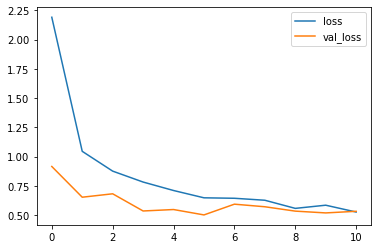

In [73]:
losses[['loss', 'val_loss']].plot()

<AxesSubplot:>

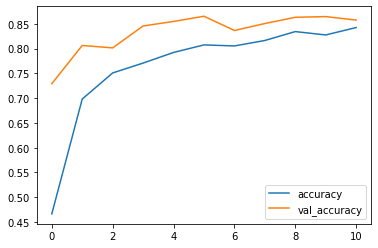

In [74]:
losses[['accuracy', 'val_accuracy']].plot()

In [ ]:
test_image_order = pd.read_csv(r"D:\Deep Learning\Hackathon\Sports Identification\Testing_set.csv")
test_image_order.head()

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model = load_model(r'D:\Deep Learning\Hackathon\Sports Identification\resnet_v2.h5')

In [ ]:
encoder = load_model(r'D:\Deep Learning\Hackathon\Sports Identification\encoder.pkl')

In [ ]:
file_paths = [[fname, 'D:/Deep Learning/Hackathon/Sports Identification/test/' + fname] for fname in test_image_order['filename']]

In [ ]:
if len(test_image_order) == len(file_paths):
    print('Number of image names i.e. ', len(test_image_order), 'matches the number of file paths i.e. ', len(file_paths))
else:
    print('Number of image names does not match the number of filepaths')

In [ ]:
test_images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
test_images.tail()

In [ ]:
from tensorflow.keras.preprocessing import image
pred = []
for i in range(len(test_images)):
    test_image = image.load_img(test_images['filepaths'][i], target_size = (299, 299))
    test_image = (image.img_to_array(test_image))/255
    test_image = test_image.reshape(1, image_shape[0], image_shape[1], 3)
    output = model.predict(test_image)
    pred.append(output)

In [ ]:
test_pred = np.array(pred)

In [ ]:
prediction = []
for i in pred:
    prediction.append(np.argmax(i))

In [ ]:
predictions = encoder.inverse_transform(prediction)

In [ ]:
res = pd.DataFrame({'filename': test_images['filename'], 'label': predictions}) 
res.to_csv(r"D:\Deep Learning\Hackathon\Sports Identification\mobilenet_submission.csv", index = False) 